#FCM++ Without U-Matrix

In [ ]:
!pip install pyclustering

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=1bf5b6715ece492cad567c27c45a9f9fc9408a02bdb5778a224178e1e5a9c059
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


Importing required packages

In [ ]:
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import timeit
import random
import matplotlib.pyplot as plt
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm

The following function updates the cluster centers in one iteration when called. The algorithm used is proposed by Kolen et. al, and reduces the time complexity of the FCM Algorithm.

It returns the updated centers and the current cost.

In [ ]:
#The FCM Algorithm without U-matrix
def Update_Centers(V,c,X,n,m):
  oldV = V
  J=0
  URS=[0]*c
  V=[0]*c
  dsqr=[0]*c
  numer3=[0]*c
  flag= -10
  for k in range(n):
    denom3=0
    flag = -10
    for i in range(c):
      dsqr[i]=sum(np.square(np.array(X[k]-oldV[i])))
      if dsqr[i]==0:
        flag=i
        continue;
      numer3[i]=(dsqr[i])**(1/(m-1))
      denom3=denom3 + (1/numer3[i])

    for i in range(c):
      if i==flag:
        u=1
        V[i]=V[i]+X[k]
        URS[i]=URS[i]+1
      else:
        u = (numer3[i]*denom3)**(-m)
        J=J+(dsqr[i]*u)
        V[i]=V[i]+(u*X[k])
        URS[i]=URS[i]+u

  for i in range(c):
    V[i]=V[i]/URS[i]


  return V,J;

#FCM Original

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import timeit
from sklearn import datasets
import random

In [ ]:
def CostFunction(U,V):
  J=0
  n=len(X)
  for i in range(n):
    for k in range(c):
      J=J+((U[i][k]**m)*sum(np.square(np.array(X[i]-V[k]))))
  return J

def initializeCenters(n,c):
  V=[]
  for i in range(c):
    x = random.randint(0,n-1)
    V.append(X[x])
  return V;

#Calculating the cluster center, is done in every iteration
def UpdateClusterCenters(U,c,m):
  V=[]
  for i in range(c):
    a=[]
    uv=[x[i] for x in U]
    uv=[x**m for x in uv]
    for j in range(len(X)):
      a.append(np.array([k*uv[j] for k in X[j]]))
    temp=sum(a)
    den=sum(uv)
    V.append(temp/den)

  return V

# Updating the membership values using the cluster centers
def updateMembershipMatrix(V,c,m):
  n=len(X)
  U=[[0 for j in range(c)] for i in range(n)]
  b=0

  for i in range(n):
    t2=0
    clust=-10
    for k in range(c):
      dist=(np.linalg.norm(X[i]-V[k]))**(2/(m-1))
      if dist==0:
        clust=k
      else:
        t2=t2+(1/dist)
      if clust!=-10:
        break
    for j in range(c):
      if clust== -10:
        den = t2*((np.linalg.norm(X[i]-V[j]))**(2/(m-1)))
        U[i][j] = 1/den
      else:
        if j!= clust:
          U[i][j]=0
        else:
          U[i][j]=1
  return U

def getClusters(U):
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(U[i]))
        cluster_labels.append(idx)
    return cluster_labels

# Real Life Data (Iris and Wine)


In [ ]:
# load list of points for cluster analysis
iris = datasets.load_iris()
X = iris.data

In [ ]:
y = iris.target

###Using FCM++ without U-matrix

In [ ]:
n = len(X)
c = 3
J_ini=0
m=1.8
time = 0
counter = 0
J=[]
for i in range(1):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()

  # initialize
  initial_centers = kmeans_plusplus_initializer(X, c, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
  V_new,J_new = Update_Centers(initial_centers,c,X,n,m)
  J_ini = 0

  while abs(J_new-J_ini) > 0.01:
    J_ini = J_new
    V_new,J_new = Update_Centers(V_new,c,X,n,m)
  stop = timeit.default_timer()
  #____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter = counter+1
  J.append(J_new)


print(time)
for i in range(c):
  V_new[i]=np.around(V_new[i],1,out=None)

print(np.mean(J))

0.04825587799950881
66.89013427891437


In [ ]:
counter

100

In [ ]:
#Creating the U Matrix
c=3
n=len(X)
m=1.8
U=[[0 for j in range(c)] for i in range(n)]

b=0
for i in range(n):
  t2=0
  clust=-10
  for k in range(c):
    dist=(np.linalg.norm(X[i]-V_new[k]))**(2/(m-1))
    if dist==0:
      clust=k
    else:
      t2=t2+(1/dist)
    if clust!=-10:
      break
  for j in range(c):
    if clust== -10:
      den = t2*((np.linalg.norm(X[i]-V_new[j]))**(2/(m-1)))
      U[i][j] = 1/den
    else:
      if j!= clust:
        U[i][j]=0
      else:
        U[i][j]=1


In [ ]:
#Creating clusters
fcm_labels=[]
for i in range(n):
  pos=U[i].index(max(U[i]))
  fcm_labels.append(pos)


In [ ]:
a = [V_new[0][0],V_new[1][0],V_new[2][0]]
print(a)
print(V_new)
b = [V_new[0][3],V_new[1][3],V_new[2][3]]
print(b)

[5.9, 5.0, 6.8]
[array([5.9, 2.8, 4.4, 1.4]), array([5. , 3.4, 1.5, 0.3]), array([6.8, 3.1, 5.7, 2.1])]
[1.4, 0.3, 2.1]


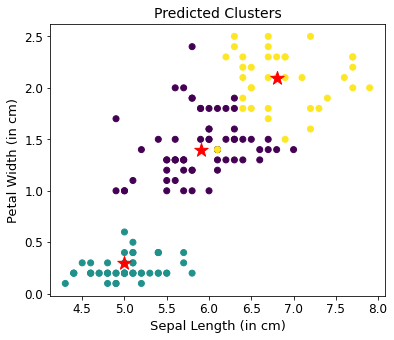

In [ ]:
# plot result
#f, axes = plt.subplots(1, 2, figsize=(11,5))
plt.figure(figsize=(6,5))
plt.title("Predicted Clusters",fontsize=14)
plt.xlabel("Sepal Length (in cm)",fontsize=13)
plt.ylabel("Petal Width (in cm)",fontsize=13)
plt.rcParams.update({'font.size': 12})
#axes[0].scatter(X[:,0], X[:,12],c=y)
#axes[1].scatter(X[:,0], X[:,12],c=fcm_labels)
#axes[1].scatter(a, b, marker="*", s=200,color='red')
plt.scatter(X[:,0], X[:,3],c=fcm_labels)
plt.scatter(a, b, marker="*", s=200,color='red')
plt.savefig("Image.png",dpi=600)
plt.show()

###Using FCM Original

In [ ]:
n = len(X)
c = 3
m = 1.8
J_ini = 0
time = 0
counter=0
J=[]
for i in range(100):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()
  V = initializeCenters(n,c)
  U = updateMembershipMatrix(V,c,m)
  J_new = CostFunction(U,V)
  J_ini = 0

  while abs(J_new-J_ini) > 0.01:
    J_ini=J_new
    V = UpdateClusterCenters(U,c,m)
    U = updateMembershipMatrix(V,c,m)
    J_new = CostFunction(U,V)

  stop = timeit.default_timer()
#____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter=counter+1
  J.append(J_new)

print(time/100)
print(np.mean(J))
cluster_labels = getClusters(U)

0.13915360526998483
73.56930468420427


[13.727226270131816, 12.44263028606197, 13.906024662584754]
[array([1.37272263e+01, 1.98664737e+00, 2.36507387e+00, 1.68929821e+01,
       1.05002522e+02, 2.79928521e+00, 2.92643539e+00, 2.76480375e-01,
       1.89322505e+00, 5.18670575e+00, 1.05195361e+00, 3.18847873e+00,
       1.06848994e+03]), array([1.24426303e+01, 2.26800221e+00, 2.28322624e+00, 2.07319657e+01,
       9.16441846e+01, 2.17679970e+00, 1.97947588e+00, 3.79785246e-01,
       1.51484928e+00, 3.80826807e+00, 9.80910623e-01, 2.60661613e+00,
       4.22858412e+02]), array([1.39060247e+01, 1.78112017e+00, 2.49879087e+00, 1.71432736e+01,
       1.06034349e+02, 2.90280513e+00, 3.06149841e+00, 2.92564183e-01,
       1.90553378e+00, 6.25461289e+00, 1.10794052e+00, 3.01419727e+00,
       1.35188398e+03]), array([1.31443401e+01, 2.59751189e+00, 2.43258653e+00, 1.93580651e+01,
       1.10368903e+02, 2.23399545e+00, 1.83028254e+00, 3.59199774e-01,
       1.61608454e+00, 5.51128693e+00, 8.92527444e-01, 2.61127418e+00,
       8.173

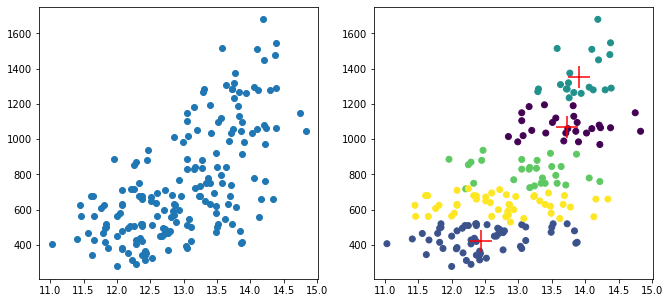

In [ ]:
# plot result
a = [V[0][0],V[1][0],V[2][0]]
print(a)
print(V)
b = [V[0][12],V[1][12],V[2][12]]
print(b)

f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(X[:,0], X[:,12])
axes[1].scatter(X[:,0], X[:,12],c=cluster_labels)
axes[1].scatter(a, b, marker="+", s=500,color='red')

plt.show()

# Make Blobs

In [ ]:
X, y = make_blobs(n_samples=200, centers=3, n_features=3, random_state=0)

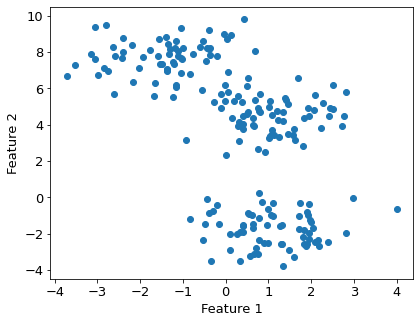

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1])
plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

###Using FCM++ without U-Matrix

In [ ]:
n = len(X)
c=6
J_ini = 0
m = 1.8
time = 0
counter = 0
J=[]
for i in range(1):
  start = timeit.default_timer()
  # initialize
  initial_centers = kmeans_plusplus_initializer(X, c, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
  V_new,J_new = Update_Centers(initial_centers,c,X,n,m)
  J_ini = 0
  while abs(J_new-J_ini)>0.01:
    J_ini = J_new
    V_new,J_new = Update_Centers(V_new,c,X,n,m)
  stop = timeit.default_timer()
  time = time+(stop-start)
  counter=counter+1
  J.append(J_new)

print(time)
print(np.mean(J))

0.1549283389995253
323.2086356157226


In [ ]:
#Creating the U Matrix
c=3
n=len(X)
m=1.8
U=[[0 for j in range(c)] for i in range(n)]

b=0
for i in range(n):
  t2=0
  clust=-10
  for k in range(c):
    dist=(np.linalg.norm(X[i]-V_new[k]))**(2/(m-1))
    if dist==0:
      clust=k
    else:
      t2=t2+(1/dist)
    if clust!=-10:
      break
  for j in range(c):
    if clust== -10:
      den = t2*((np.linalg.norm(X[i]-V_new[j]))**(2/(m-1)))
      U[i][j] = 1/den
    else:
      if j!= clust:
        U[i][j]=0
      else:
        U[i][j]=1

In [ ]:
#Creating clusters

fcm_labels=[]
for i in range(n):
  pos=U[i].index(max(U[i]))
  fcm_labels.append(pos)


In [ ]:
V_new_2=[x[:2] for x in V_new]
initial_centers_2=[x[:2] for x in initial_centers]

a = [V_new[0][0],V_new[1][0],V_new[2][0]]
print(a)
print(V_new)
b = [V_new[0][1],V_new[1][1],V_new[2][1]]
print(b)

[1.0715091191056436, -0.8754299259184835, 1.3134387313310498]
[array([1.07150912, 4.57640877, 1.77263884]), array([-0.87542993,  7.93946094,  9.57345065]), array([ 1.31343873, -2.50922415,  2.55436231]), array([-2.00395378,  7.47064088,  8.73374956]), array([ 1.6709134 , -0.70439608,  1.59550789]), array([ 0.43018144, -1.12163595,  3.12310363])]
[4.576408772615125, 7.939460944431592, -2.5092241458172713]


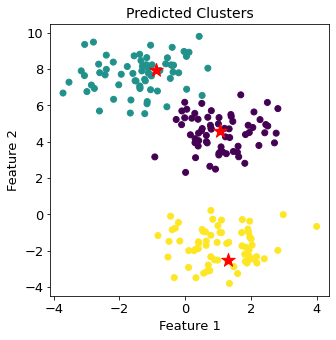

In [ ]:
# plot result
#f, axes = plt.subplots(1, 2, figsize=(11,5))
plt.figure(figsize=(5,5))
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.title("Predicted Clusters",fontsize=14)
#axes[0].scatter(X[:,0], X[:,1])
#axes[1].scatter(X[:,0], X[:,1],c=y)
#axes[1].scatter(a, b, marker="*", s=200,color='red')
plt.scatter(X[:,0], X[:,1],c=fcm_labels)
plt.rcParams.update({'font.size': 13})
plt.scatter(a, b, marker="*", s=200,color='red')
plt.savefig("Image.png",dpi=600)
plt.show()

###Using FCM Original

In [ ]:
n = len(X)
c = 6
m = 1.8
J_ini = 0
time = 0
counter=0
J=[]
for i in range(100):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()
  V = initializeCenters(n,c)
  U = updateMembershipMatrix(V,c,m)
  J_new = CostFunction(U,V)
  while abs(J_new-J_ini) > 0.01:
    J_ini=J_new
    V = UpdateClusterCenters(U,c,m)
    U = updateMembershipMatrix(V,c,m)
    J_new = CostFunction(U,V)

  stop = timeit.default_timer()
#____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter=counter+1
  J.append(J_new)


print(time/100)
print(np.mean(J))


0.8403552427299473
318.6495103869228


In [ ]:
cluster_labels = getClusters(U)

[-1.2861101725167332, 1.084552084487684]
[array([-1.28611017,  7.58383606,  8.91953088]), array([1.08455208, 1.0118752 , 2.17758813])]
[7.583836059811372, 1.0118752005904332]


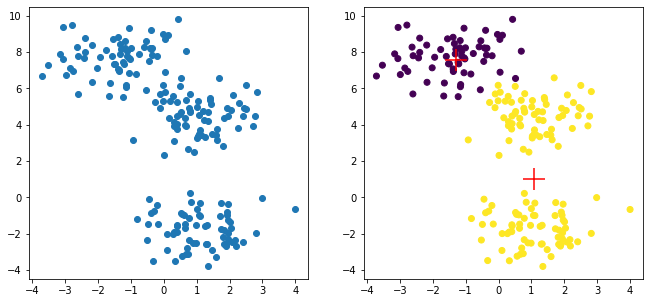

In [ ]:
# plot result
a = [V[0][0],V[1][0],,V[2][0]]
print(a)
print(V)
b = [V[0][1],V[1][1],,V[2][1]]
print(b)

f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(X[:,0], X[:,1])
axes[1].scatter(X[:,0], X[:,1],c=cluster_labels)
axes[1].scatter(a, b, marker="+", s=500,color='red')

plt.show()

# Synthetic Data

In [ ]:
#Creating artificial dataset
n_samples = 250
random.seed(10)
X = np.concatenate((
    np.random.normal((-3, 1),1, size=(n_samples, 2)),
    np.random.normal((2, 2),0.5, size=(n_samples, 2)),
    np.random.normal((1, -3),1.5, size=(n_samples, 2)),
    np.random.normal((5, 4),2, size=(n_samples, 2))
))
y = np.concatenate((([0]*250),([1]*250),([2]*250),([3]*250)))

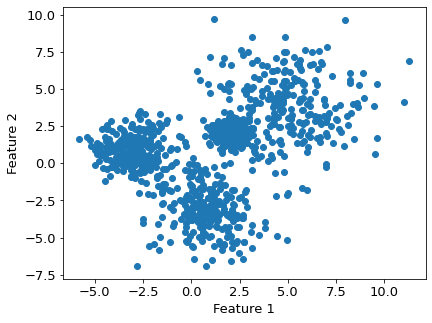

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1])
plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

###Using FCM++ without U-Matrix

In [ ]:
n = len(X)
c = 4
J_ini = 0
m = 1.8
time = 0
counter = 0
J=[]
for i in range(1):
  start = timeit.default_timer()
  # initialize
  initial_centers = kmeans_plusplus_initializer(X, c, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
  V_new,J_new = Update_Centers(initial_centers,c,X,n,m)
  while abs(J_new-J_ini)>0.01:
    J_ini = J_new
    V_new,J_new = Update_Centers(V_new,c,X,n,m)
  stop = timeit.default_timer()
  time = time+(stop-start)
  counter=counter+1
  J.append(J_new)
  print(counter)

print(time)
print(np.mean(J))

1
0.49454247999892686
2442.8203364847145


In [ ]:
#Creating the U Matrix
c=4
n=len(X)
m=1.8
U=[[0 for j in range(c)] for i in range(n)]

b=0
for i in range(n):
  t2=0
  clust=-10
  for k in range(c):
    dist=(np.linalg.norm(X[i]-V_new[k]))**(2/(m-1))
    if dist==0:
      clust=k
    else:
      t2=t2+(1/dist)
    if clust!=-10:
      break
  for j in range(c):
    if clust== -10:
      den = t2*((np.linalg.norm(X[i]-V_new[j]))**(2/(m-1)))
      U[i][j] = 1/den
    else:
      if j!= clust:
        U[i][j]=0
      else:
        U[i][j]=1

In [ ]:
#Creating clusters

fcm_labels=[]
for i in range(n):
  pos=U[i].index(max(U[i]))
  fcm_labels.append(pos)


In [ ]:
a = [V_new[0][0],V_new[1][0],V_new[2][0],V_new[3][0]]
print(a)
print(V_new)
b = [V_new[0][1],V_new[1][1],V_new[2][1],V_new[3][1]]
print(b)

[-3.0200062550755873, 5.64680550876315, 0.9190017293308875, 2.165106967993898]
[array([-3.02000626,  0.86479726]), array([5.64680551, 4.44493794]), array([ 0.91900173, -3.41952102]), array([2.16510697, 2.06080191])]
[0.8647972558402468, 4.444937941416501, -3.4195210182036093, 2.0608019143639478]


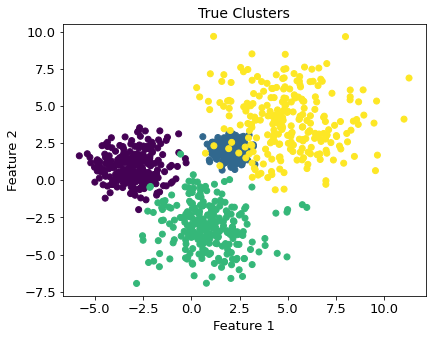

In [ ]:
# plot result
#f, axes = plt.subplots(1, 2, figsize=(11,5))
plt.figure(figsize=(6.5,5))
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.title("True Clusters",fontsize=14)
#axes[0].scatter(X[:,0], X[:,1])
#axes[1].scatter(X[:,0], X[:,1],c=y)
#axes[1].scatter(a, b, marker="*", s=200,color='red')
plt.scatter(X[:,0], X[:,1],c=y)
plt.rcParams.update({'font.size': 13})
#plt.scatter(a, b, marker="*", s=200,color='red')
plt.savefig("Image.png",dpi=600)
plt.show()

###Using FCM Original

In [ ]:
n = len(X)
c = 6
m = 1.8
J_ini = 0
time = 0
counter=0
J=[]
for i in range(100):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()
  V = initializeCenters(n,c)
  U = updateMembershipMatrix(V,c,m)
  J_new = CostFunction(U,V)
  while abs(J_new-J_ini) > 0.01:
    J_ini=J_new
    V = UpdateClusterCenters(U,c,m)
    U = updateMembershipMatrix(V,c,m)
    J_new = CostFunction(U,V)

  stop = timeit.default_timer()
#____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter=counter+1
  J.append(J_new)
  #print(counter)


print(time/100)
print(np.mean(J))


In [ ]:
cluster_labels = getClusters(U)

[5.739708770164052, 1.1214397979853559, -3.0539561568685714, 2.1326011896509507]
[array([5.73970877, 4.76317118]), array([ 1.1214398, -3.3092643]), array([-3.05395616,  0.90820108]), array([2.13260119, 2.08417245])]
[4.763171176521415, -3.309264300157831, 0.9082010794361937, 2.0841724546677374]


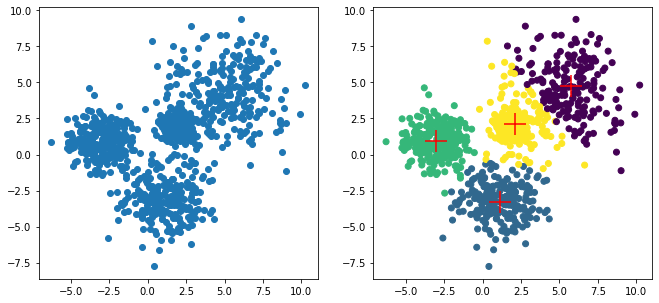

In [ ]:
# plot result
a = [V[0][0],V[1][0],V[2][0],V[3][0]]
print(a)
print(V)
b = [V[0][1],V[1][1],V[2][1],V[3][1]]
print(b)

f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(X[:,0], X[:,1])
axes[1].scatter(X[:,0], X[:,1],c=cluster_labels)
axes[1].scatter(a, b, marker="+", s=500,color='red')

plt.show()

# Using Cancer Dataset

In [ ]:
# load list of points for cluster analysis
cancer = datasets.load_breast_cancer()
X = cancer.data

In [ ]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [ ]:
y = cancer.target

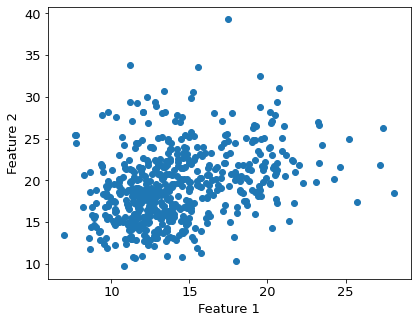

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1])
plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

###Using FCM++ without U

In [ ]:
n = len(X)
c = 3
J_ini=0
m = 1.8
time = 0
counter = 0
J=[]
for i in range(1):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()

  # initialize
  initial_centers = kmeans_plusplus_initializer(X, c, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
  V_new,J_new = Update_Centers(initial_centers,c,X,n,m)
  J_ini = 0

  while abs(J_new-J_ini) > 0.01:
    J_ini = J_new
    V_new,J_new = Update_Centers(V_new,c,X,n,m)
  stop = timeit.default_timer()
  #____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter = counter+1
  J.append(J_new)


print(time)
print(np.mean(J))

8.250696814999174
39549469.593492985


In [ ]:
#Creating the U Matrix
c=3
n=len(X)
m=1.8
U=[[0 for j in range(c)] for i in range(n)]

b=0
for i in range(n):
  t2=0
  clust=-10
  for k in range(c):
    dist=(np.linalg.norm(X[i]-V_new[k]))**(2/(m-1))
    if dist==0:
      clust=k
    else:
      t2=t2+(1/dist)
    if clust!=-10:
      break
  for j in range(c):
    if clust== -10:
      den = t2*((np.linalg.norm(X[i]-V_new[j]))**(2/(m-1)))
      U[i][j] = 1/den
    else:
      if j!= clust:
        U[i][j]=0
      else:
        U[i][j]=1

In [ ]:
#Creating clusters

fcm_labels=[]
for i in range(n):
  pos=U[i].index(max(U[i]))
  fcm_labels.append(pos)

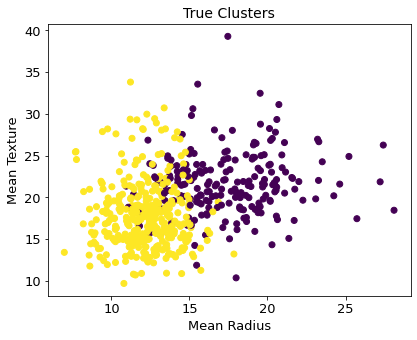

In [ ]:
# plot result

plt.figure(figsize=(6.5,5))
plt.xlabel("Mean Radius",fontsize=13)
plt.ylabel("Mean Texture",fontsize=13)
plt.title("True Clusters",fontsize=14)

plt.scatter(X[:,0], X[:,1],c=y)
plt.rcParams.update({'font.size': 13})

#plt.savefig("Image.png",dpi=600)
plt.show()

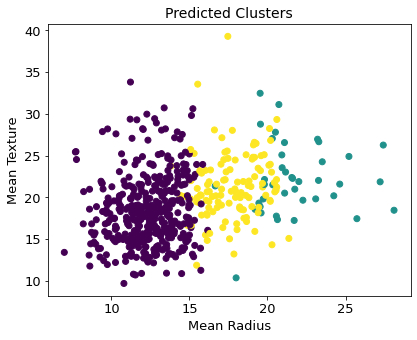

In [ ]:
plt.figure(figsize=(6.5,5))
plt.xlabel("Mean Radius",fontsize=13)
plt.ylabel("Mean Texture",fontsize=13)
plt.title("Predicted Clusters",fontsize=14)

plt.scatter(X[:,0], X[:,1],c=fcm_labels)
plt.rcParams.update({'font.size': 13})

#plt.savefig("Image.png",dpi=600)
plt.show()

###Using FCM Original

In [ ]:
n = len(X)
c = 6
m = 1.8
J_ini = 0
time = 0
counter=0
J=[]
for i in range(20):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()
  V = initializeCenters(n,c)
  U = updateMembershipMatrix(V,c,m)
  J_new = CostFunction(U,V)
  while abs(J_new-J_ini) > 0.01:
    J_ini=J_new
    V = UpdateClusterCenters(U,c,m)
    U = updateMembershipMatrix(V,c,m)
    J_new = CostFunction(U,V)

  stop = timeit.default_timer()
#____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter=counter+1
  J.append(J_new)
  #print(counter)


print(time/20)
print(np.mean(J))

13.870535301949804
12490418.90778731


In [ ]:
cluster_labels = getClusters(U)

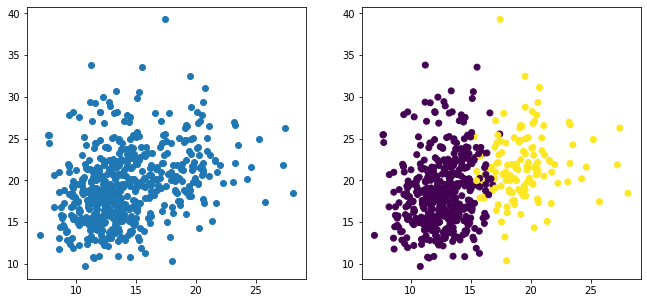

In [ ]:
# plot result
'''a = [V[0][0],V[1][0],V[2][0],V[3][0]]
print(a)
print(V)
b = [V[0][1],V[1][1],V[2][1],V[3][1]]
print(b)'''

f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(X[:,0], X[:,1])
axes[1].scatter(X[:,0], X[:,1],c=cluster_labels)
#axes[1].scatter(a, b, marker="+", s=500,color='red')

plt.show()

# Moons (Synthetic)

In [ ]:
X,y = datasets.make_moons(n_samples=(100,100),noise=0.08,random_state=0)
print(X[:5,:])
print(y[:5])

[[ 0.80213659  0.51024702]
 [ 1.62638846 -0.43026973]
 [-0.04877337  0.27015154]
 [-1.03519872 -0.1397405 ]
 [ 1.76684746 -0.18744542]]
[0 1 1 0 1]


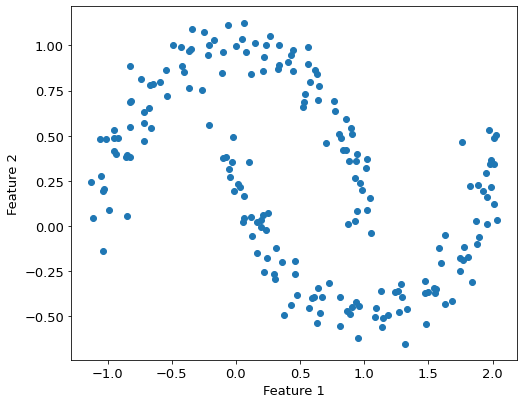

In [ ]:
plt.figure(figsize=(8,6.5))
plt.scatter(X[:,0],X[:,1])
plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

### Using FCM++ without U-matrix

In [ ]:
n = len(X)
c = 2
J_ini=0
m=1.8
time = 0
counter = 0
J=[]
for i in range(50):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()

  # initialize
  initial_centers = kmeans_plusplus_initializer(X, c, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
  V_new,J_new = Update_Centers(initial_centers,c,X,n,m)
  J_ini = 0

  while abs(J_new-J_ini) > 0.01:
    J_ini = J_new
    V_new,J_new = Update_Centers(V_new,c,X,n,m)
  stop = timeit.default_timer()
  #____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter = counter+1
  J.append(J_new)


print(time/50)
for i in range(c):
  V_new[i]=np.around(V_new[i],1,out=None)

print(np.mean(J))

0.05640005685974756
69.39514010343233


In [ ]:
#Creating the U Matrix
c=2
n=len(X)
m=1.8
U=[[0 for j in range(c)] for i in range(n)]

b=0
for i in range(n):
  t2=0
  clust=-10
  for k in range(c):
    dist=(np.linalg.norm(X[i]-V_new[k]))**(2/(m-1))
    if dist==0:
      clust=k
    else:
      t2=t2+(1/dist)
    if clust!=-10:
      break
  for j in range(c):
    if clust== -10:
      den = t2*((np.linalg.norm(X[i]-V_new[j]))**(2/(m-1)))
      U[i][j] = 1/den
    else:
      if j!= clust:
        U[i][j]=0
      else:
        U[i][j]=1

In [ ]:
#Creating clusters

fcm_labels=[]
for i in range(n):
  pos=U[i].index(max(U[i]))
  fcm_labels.append(pos)

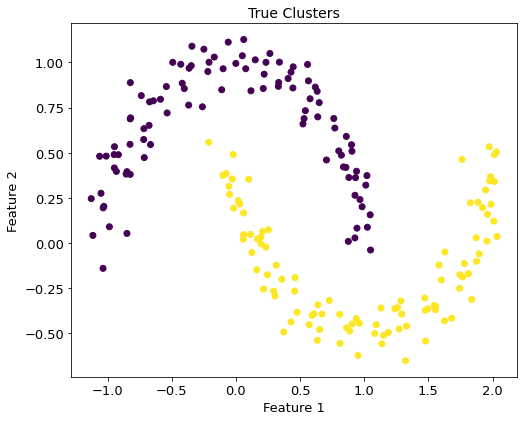

In [ ]:
# plot result

plt.figure(figsize=(8,6.5))
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.title("True Clusters",fontsize=14)

plt.scatter(X[:,0], X[:,1],c=y)
plt.rcParams.update({'font.size': 13})

plt.savefig("Image.png",dpi=600)
plt.show()

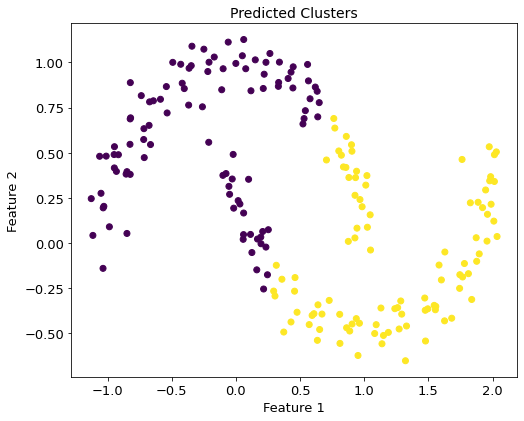

In [ ]:
plt.figure(figsize=(8,6.5))
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.title("Predicted Clusters",fontsize=14)

plt.scatter(X[:,0], X[:,1],c=fcm_labels)
plt.rcParams.update({'font.size': 13})

plt.savefig("Image.png",dpi=600)
plt.show()

### Using FCM Original

In [ ]:
n = len(X)
c = 6
m = 1.8
J_ini = 0
time = 0
counter=0
J=[]
for i in range(50):
  #___________________________________TIMER STARTS___________________
  start = timeit.default_timer()
  V = initializeCenters(n,c)
  U = updateMembershipMatrix(V,c,m)
  J_new = CostFunction(U,V)
  while abs(J_new-J_ini) > 0.01:
    J_ini=J_new
    V = UpdateClusterCenters(U,c,m)
    U = updateMembershipMatrix(V,c,m)
    J_new = CostFunction(U,V)

  stop = timeit.default_timer()
#____________________________________TIMER ENDS_____________________
  time = time+(stop-start)
  counter=counter+1
  J.append(J_new)
  #print(counter)


print(time/50)
print(np.mean(J))

0.6045649337799841
14.957394770699004


In [ ]:
cluster_labels = getClusters(U)

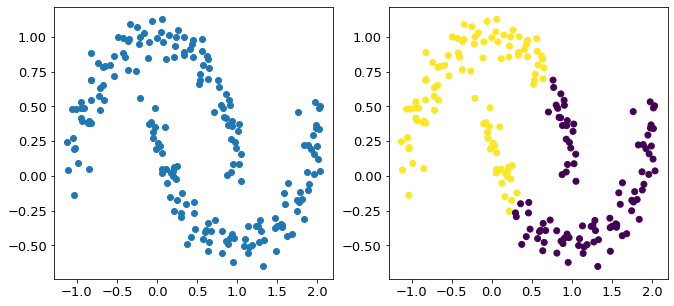

In [ ]:
# plot result
'''a = [V[0][0],V[1][0],V[2][0],V[3][0]]
print(a)
print(V)
b = [V[0][1],V[1][1],V[2][1],V[3][1]]
print(b)'''

f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(X[:,0], X[:,1])
axes[1].scatter(X[:,0], X[:,1],c=cluster_labels)
#axes[1].scatter(a, b, marker="+", s=500,color='red')

plt.show()

# Checking Robustness

In [ ]:
def perturb(data):

  X = np.array([x for x in data])

  n = np.round(0.2*len(X)).astype(int)
  pos = np.random.randint(low=0,high=len(X),size=n)
  dim = X.shape

  for i in pos:
    z = np.random.normal(loc=0,scale=0.15,size=(1,dim[1]))
    X[i] = (1+z)*X[i]

  return X

def FCM_new(X,c):
  n = len(X)
  J_ini = 0
  m = 1.8
  time = 0
  counter = 0
  J=[]
  for i in range(50):
    start = timeit.default_timer()
    # initialize
    initial_centers = kmeans_plusplus_initializer(X, c, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
    V_new,J_new = Update_Centers(initial_centers,c,X,n,m)
    while abs(J_new-J_ini)>0.01:
      J_ini = J_new
      V_new,J_new = Update_Centers(V_new,c,X,n,m)
    stop = timeit.default_timer()
    time = time+(stop-start)
    counter=counter+1
    J.append(J_new)

  time = time/50
  J = np.mean(J)

  return(V_new,J)

def UMatrix(X,V_new,c):

  #Creating the U Matrix

  n=len(X)
  m=1.8
  U=[[0 for j in range(c)] for i in range(n)]

  b=0
  for i in range(n):
    t2=0
    clust=-10
    for k in range(c):
      dist=(np.linalg.norm(X[i]-V_new[k]))**(2/(m-1))
      if dist==0:
        clust=k
      else:
        t2=t2+(1/dist)
      if clust!=-10:
        break
    for j in range(c):
      if clust== -10:
        den = t2*((np.linalg.norm(X[i]-V_new[j]))**(2/(m-1)))
        U[i][j] = 1/den
      else:
        if j!= clust:
          U[i][j]=0
        else:
          U[i][j]=1

  return U

def ClusterLabels(U):
  n = len(U)
  fcm_labels=[]
  for i in range(n):
    pos=U[i].index(max(U[i]))
    fcm_labels.append(pos)
  return fcm_labels

##Iris

In [ ]:
# load list of points for cluster analysis
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
X_new = perturb(X)
V_new,J = FCM_new(X_new,c=3)
U = UMatrix(X_new,V_new,c=3)
fcm_labels_pert = ClusterLabels(U)

V_new,J = FCM_new(X,c=3)
U = UMatrix(X,V_new,c=3)
fcm_labels = ClusterLabels(U)

adjusted_rand_score(fcm_labels_pert,fcm_labels)

0.9021340992480396

In [ ]:
Xval = np.array(list(X_new[:,0])+list(X[:,0]))
Yval = np.array(list(X_new[:,3])+list(X[:,3]))
xmin = np.min(Xval)-0.2
xmax = np.max(Xval)+0.2
ymin = np.min(Yval)-0.2
ymax = np.max(Yval)+0.2

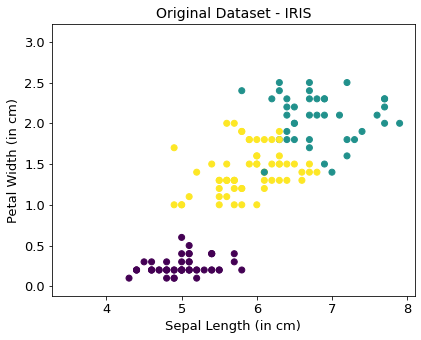

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X[:,0],X[:,3],c=fcm_labels)
plt.rcParams.update({'font.size': 13})
plt.xlabel("Sepal Length (in cm)",fontsize=13)
plt.ylabel("Petal Width (in cm)",fontsize=13)
plt.title("Original Dataset - IRIS",fontsize=14)
plt.savefig("Image.png",dpi=600)
plt.show()

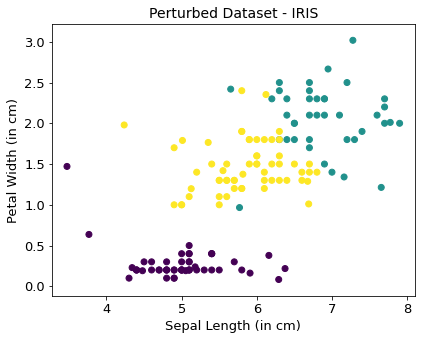

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X_new[:,0],X_new[:,3],c=fcm_labels_pert)
plt.rcParams.update({'font.size': 13})
plt.title("Perturbed Dataset - IRIS",fontsize=14)
plt.xlabel("Sepal Length (in cm)",fontsize=13)
plt.ylabel("Petal Width (in cm)",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

##Wine

In [ ]:
# load list of points for cluster analysis
wine = datasets.load_wine()
X = wine.data
y = wine.target

In [ ]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [ ]:
X_new = perturb(X)
V_new,J = FCM_new(X_new,c=3)
U = UMatrix(X_new,V_new,c=3)
fcm_labels_pert = ClusterLabels(U)

V_new,J = FCM_new(X,c=3)
U = UMatrix(X,V_new,c=3)
fcm_labels = ClusterLabels(U)

adjusted_rand_score(fcm_labels_pert,fcm_labels)

0.9337681707559197

In [ ]:
Xval = list(X_new[:,0])+list(X[:,0])
Yval = list(X_new[:,12])+list(X[:,12])
xmin = np.min(Xval)-1
xmax = np.max(Xval)+1
ymin = np.min(Yval)-50
ymax = np.max(Yval)+50

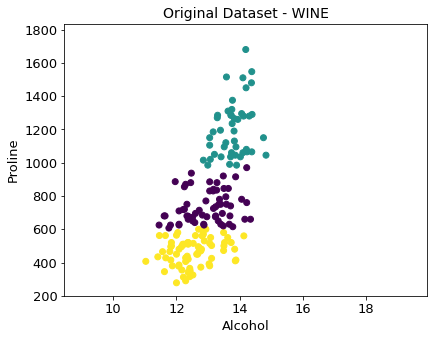

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X[:,0],X[:,12],c=fcm_labels)
plt.rcParams.update({'font.size': 13})
plt.title("Original Dataset - WINE",fontsize=14)
plt.xlabel("Alcohol",fontsize=13)
plt.ylabel("Proline",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

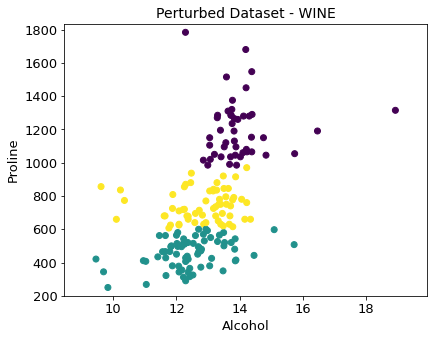

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X_new[:,0],X_new[:,12],c=fcm_labels_pert)
plt.rcParams.update({'font.size': 13})
plt.title("Perturbed Dataset - WINE",fontsize=14)
plt.xlabel("Alcohol",fontsize=13)
plt.ylabel("Proline",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

##Blobs

In [ ]:
X, y = make_blobs(n_samples=200, centers=3, n_features=3, random_state=0)

In [ ]:
X_new = perturb(X)
V_new,J = FCM_new(X_new,c=3)
U = UMatrix(X_new,V_new,c=3)
fcm_labels_pert = ClusterLabels(U)

V_new,J = FCM_new(X,c=3)
U = UMatrix(X,V_new,c=3)
fcm_labels = ClusterLabels(U)

adjusted_rand_score(fcm_labels_pert,fcm_labels)

1.0

In [ ]:
Xval = np.array(list(X_new[:,0])+list(X[:,0]))
Yval = np.array(list(X_new[:,1])+list(X[:,1]))
xmin = np.min(Xval)-1
xmax = np.max(Xval)+1
ymin = np.min(Yval)-2
ymax = np.max(Yval)+2

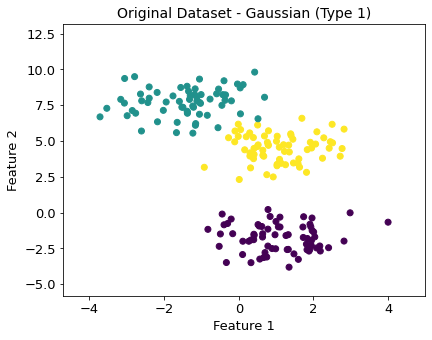

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X[:,0],X[:,1],c=fcm_labels)
plt.rcParams.update({'font.size': 13})
plt.title("Original Dataset - Gaussian (Type 1)",fontsize=14)
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

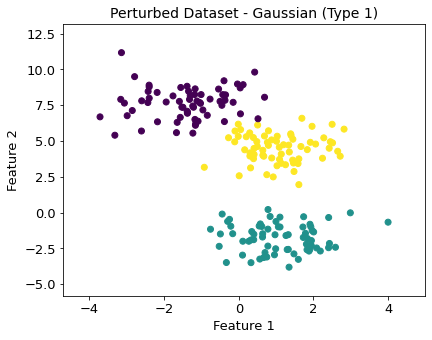

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X_new[:,0],X_new[:,1],c=fcm_labels_pert)
plt.rcParams.update({'font.size': 13})
plt.title("Perturbed Dataset - Gaussian (Type 1)",fontsize=14)
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

##Synthetic

In [ ]:
#Creating artificial dataset
n_samples = 250
random.seed(10)
X = np.concatenate((
    np.random.normal((-3, 1),1, size=(n_samples, 2)),
    np.random.normal((2, 2),0.5, size=(n_samples, 2)),
    np.random.normal((1, -3),1.5, size=(n_samples, 2)),
    np.random.normal((5, 4),2, size=(n_samples, 2))
))
y = np.concatenate((([0]*250),([1]*250),([2]*250),([3]*250)))

In [ ]:
X_new = perturb(X)
V_new,J = FCM_new(X_new,c=4)
U = UMatrix(X_new,V_new,c=4)
fcm_labels_pert = ClusterLabels(U)

V_new,J = FCM_new(X,c=4)
U = UMatrix(X,V_new,c=4)
fcm_labels = ClusterLabels(U)

adjusted_rand_score(fcm_labels_pert,fcm_labels)

0.975914922152598

In [ ]:
Xval = np.array(list(X_new[:,0])+list(X[:,0]))
Yval = np.array(list(X_new[:,1])+list(X[:,1]))
xmin = np.min(Xval)-1
xmax = np.max(Xval)+1
ymin = np.min(Yval)-1
ymax = np.max(Yval)+1

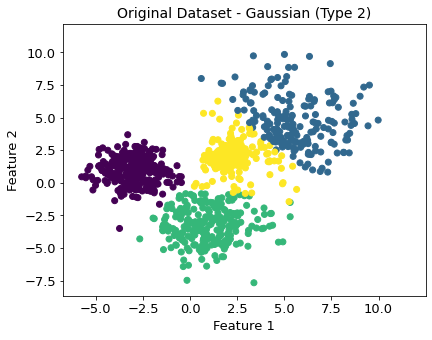

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X[:,0],X[:,1],c=fcm_labels)
plt.rcParams.update({'font.size': 13})
plt.title("Original Dataset - Gaussian (Type 2)",fontsize=14)
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

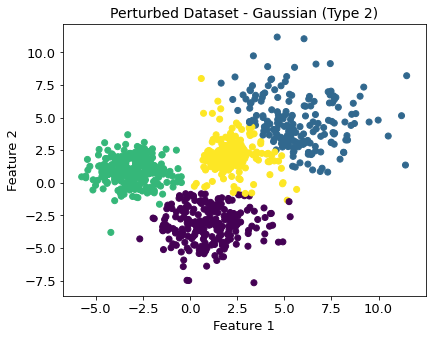

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X_new[:,0],X_new[:,1],c=fcm_labels_pert)
plt.rcParams.update({'font.size': 13})
plt.title("Perturbed Dataset - Gaussian (Type 2)",fontsize=14)
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.savefig("Image.png",dpi=600)
plt.show()

##Breast Cancer

In [ ]:
# load list of points for cluster analysis
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

In [ ]:
X_new = perturb(X)
V_new,J = FCM_new(X_new,c=2)
U = UMatrix(X_new,V_new,c=2)
fcm_labels_pert = ClusterLabels(U)

V_new,J = FCM_new(X,c=2)
U = UMatrix(X,V_new,c=2)
fcm_labels = ClusterLabels(U)

adjusted_rand_score(fcm_labels_pert,fcm_labels)

0.9693890473034174

In [ ]:
Xval = np.array(list(X_new[:,0])+list(X[:,0]))
Yval = np.array(list(X_new[:,1])+list(X[:,1]))
xmin = np.min(Xval)-3
xmax = np.max(Xval)+3
ymin = np.min(Yval)-5
ymax = np.max(Yval)+5

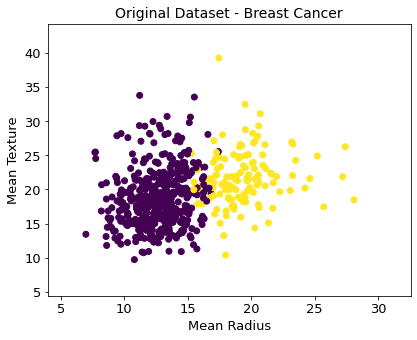

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X[:,0],X[:,1],c=fcm_labels)
plt.rcParams.update({'font.size': 13})
plt.xlabel("Mean Radius",fontsize=13)
plt.ylabel("Mean Texture",fontsize=13)
plt.title("Original Dataset - Breast Cancer",fontsize=14)
plt.savefig("Image.png",dpi=600)
plt.show()

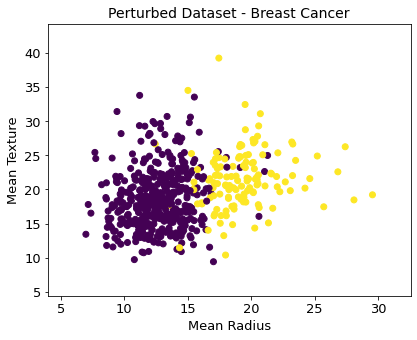

In [ ]:
plt.figure(figsize=(6.5,5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X_new[:,0],X_new[:,1],c=fcm_labels_pert)
plt.rcParams.update({'font.size': 13})
plt.title("Perturbed Dataset - Breast Cancer",fontsize=14)
plt.xlabel("Mean Radius",fontsize=13)
plt.ylabel("Mean Texture",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

##Crescents

In [ ]:
X,y = datasets.make_moons(n_samples=(100,100),noise=0.08,random_state=0)

In [ ]:
X_new = perturb(X)
V_new,J = FCM_new(X_new,c=2)
U = UMatrix(X_new,V_new,c=2)
fcm_labels_pert = ClusterLabels(U)

V_new,J = FCM_new(X,c=2)
U = UMatrix(X,V_new,c=2)
fcm_labels = ClusterLabels(U)

adjusted_rand_score(fcm_labels_pert,fcm_labels)

0.979999618992262

In [ ]:
Xval = np.array(list(X_new[:,0])+list(X[:,0]))
Yval = np.array(list(X_new[:,1])+list(X[:,1]))
xmin = np.min(Xval)-0.2
xmax = np.max(Xval)+0.2
ymin = np.min(Yval)-0.2
ymax = np.max(Yval)+0.2

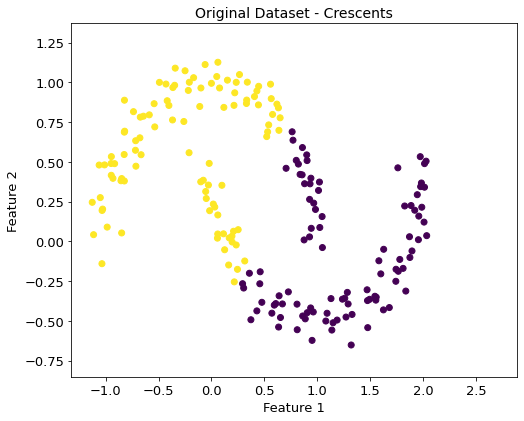

In [ ]:
plt.figure(figsize=(8,6.5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X[:,0],X[:,1],c=fcm_labels)
plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.title("Original Dataset - Crescents",fontsize=14)
plt.savefig("Image.png",dpi=600)
plt.show()

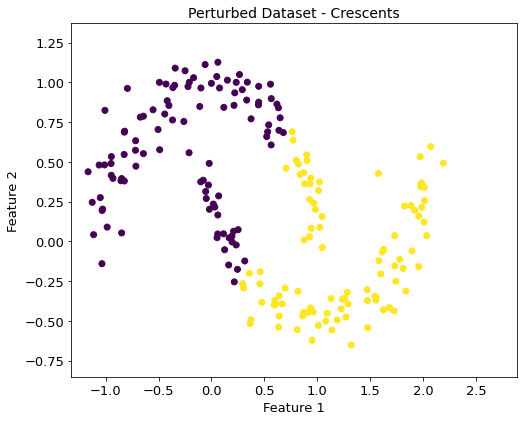

In [ ]:
plt.figure(figsize=(8,6.5))
ax = plt.gca()
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylim(bottom=ymin, top=ymax)
plt.scatter(X_new[:,0],X_new[:,1],c=fcm_labels_pert)
plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
plt.title("Perturbed Dataset - Crescents",fontsize=14)
plt.savefig("Image.png",dpi=600)
plt.show()

#Regression to show faster convergence

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_coef(x,y):
  n = np.size(x)  #number of points

  mx = np.mean(x) #mean of x and y vector
  my = np.mean(y)

  ssxy = np.sum(y*x) - n*my*mx
  ssxx = np.sum(x*x) - n*mx*mx

  b1 = ssxy/ssxx
  b0 = my - b1*mx

  return(b0,b1)

In [ ]:
def plot_regression_line(x,y,b,colsc,colline,lab):

  plt.scatter(x,y,color=colsc,marker="o",s=30)  #plotting the actual points as a scatter plot
  y_pred = b[0] + b[1]*x  #predicted response vector
  plt.plot(x,y_pred,color=colline,label=lab)  #plotting the regression line
  plt.rcParams.update({'font.size': 12})
  plt.xlabel("Number of clusters",fontsize=13)
  plt.ylabel("Time in seconds",fontsize=13)


Estimated coefficients:
b_0 = -0.10939999999999939 
b_1 = 0.12429999999999986
Estimated coefficients:
b_0 = 0.004599999999999993 
b_1 = 0.0415


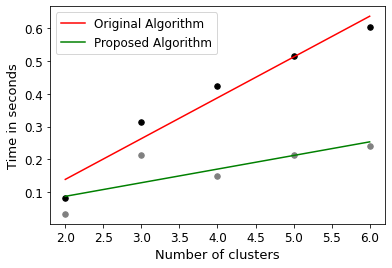

In [ ]:
x = np.array([2, 3, 4, 5, 6])
yor = np.array([0.083,0.314,0.423,0.515,0.604])
ypr = np.array([0.034,0.213,0.151,0.214,0.241])

	# estimating coefficients
b1 = estimate_coef(x, yor)
print("Estimated coefficients:\nb_0 = {} \nb_1 = {}".format(b1[0], b1[1]))
b2 = estimate_coef(x,ypr)
print("Estimated coefficients:\nb_0 = {} \nb_1 = {}".format(b2[0], b2[1]))

  # plotting regression line
myfig = plot_regression_line(x, yor, b1,"black","red","Original Algorithm")
myfig = plot_regression_line(x,ypr,b2,"gray","green","Proposed Algorithm")

  # function to show plot
myfig = plt.legend(loc="upper left",fontsize=12)
plt.savefig("Image.png",dpi=600)
  #plt.show()
